# <span style="font-size: 25pt;">**Bayesian Analysis of Barrel % Predictors in MLB Hitters (2021-2024)**</span>
**Lucas Ben** | Data Scientist | April 2025  

---

## Summary  

### The Power Hitter Premium  
**Strong positive effect (β = 0.51, 95% Credible Interval [0.47, 0.56])**  
- Suggests "all-or-nothing" hitters generate **higher-quality contact** when they connect  

### Age is Just a Number  
**No significant impact (β = 0.02, 95% Credible Interval [-0.02, 0.06])**  
- Barrel rate remains stable across MLB career
- Bat-to-ball skills > age  

---

## Strategic Implications  
**Re-evaluate high K % hitters** - The "three true outcomes" approach (HR/BB/K) may be **underrated** when barrels compensate for strikeouts  

---


In [59]:
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

In [15]:
data = pd.read_csv('statcast batter data 2021-2024.csv')

# creating subset for regression
numeric_data = data[['player_age', 'k_percent', 'barrel_batted_rate']].copy()

# converting 'player_age' to float
numeric_data['player_age'] = pd.to_numeric(numeric_data['player_age'], errors='coerce').astype('float64')

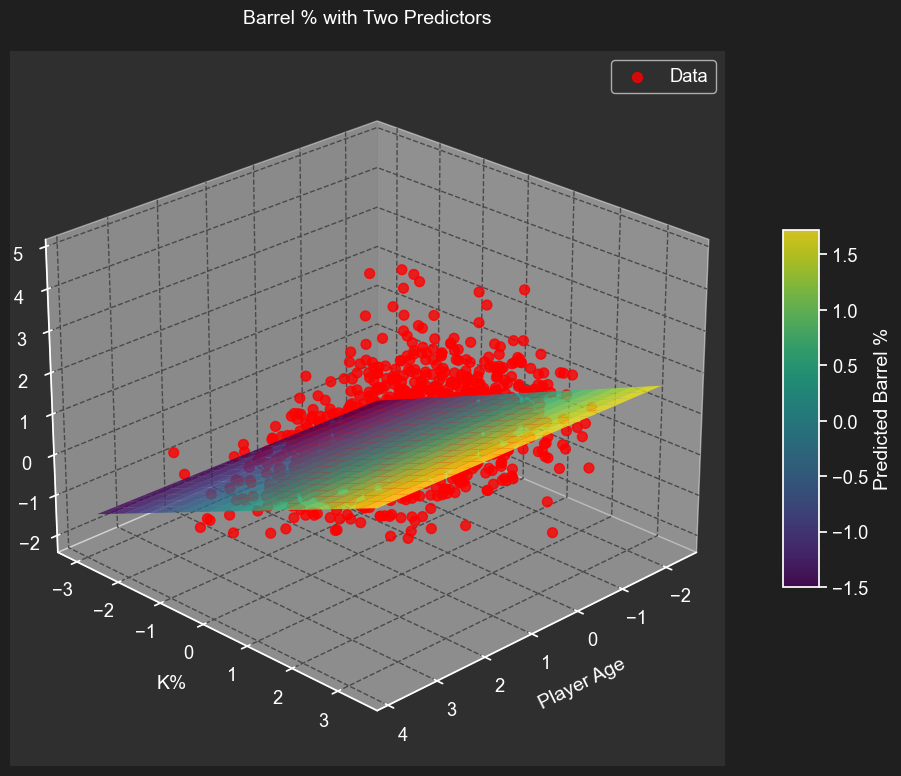

In [97]:
# fitting linear regression model
X = numeric_data[['player_age', 'k_percent']].values
y = numeric_data['barrel_batted_rate'].values
reg = LinearRegression().fit(X, y)

# creating grid for surface plot
age_range = np.linspace(numeric_data['player_age'].min(), numeric_data['player_age'].max(), 20)
kperc_range = np.linspace(numeric_data['k_percent'].min(), numeric_data['k_percent'].max(), 20)
Age, Kperc = np.meshgrid(age_range, kperc_range)
Z = reg.intercept_ + reg.coef_[0]*Age + reg.coef_[1]*Kperc

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(Age, Kperc, Z, cmap='viridis', alpha=0.8, 
                      linewidth=0, antialiased=True)

ax.scatter(numeric_data['player_age'], numeric_data['k_percent'], 
           numeric_data['barrel_batted_rate'], 
           c='red', s=50, alpha=0.8, label='Data')

ax.set_xlabel('Player Age', fontsize=14, labelpad=10)
ax.set_ylabel('K%', fontsize=14, labelpad=10)
ax.set_zlabel('Barrel Rate', fontsize=14, labelpad=10)
ax.set_title('Barrel % with Two Predictors', fontsize=14, pad=20)
fig.colorbar(surf, shrink=0.5, aspect=10, label='Predicted Barrel %')
ax.legend()

ax.view_init(elev=25, azim=45) 

plt.tight_layout()
plt.show()

In [92]:
# fitting linear regression model
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     256.9
Date:                Fri, 04 Apr 2025   Prob (F-statistic):           3.50e-96
Time:                        21:18:58   Log-Likelihood:                -1833.0
No. Observations:                1447   AIC:                             3672.
Df Residuals:                    1444   BIC:                             3688.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.966e-17      0.023    2.2e-15      1.0

# <span style="font-size: 25pt;">**Model Fitting**</span>

# **Bayes' Formula**

# $$ L(\theta \mid x_{1:n}) = \frac{f(x_{1:n} \mid \theta) \cdot f(\theta)}{f(x_{1:n})} $$

# **Priors**
\begin{aligned}
\alpha &\sim \mathcal{N}(0, 10^2) \\
\beta_1 &\sim \mathcal{N}(0, 10^2) \\
\beta_2 &\sim \mathcal{N}(0, 10^2) \\
\sigma &\sim \mathcal{N}^+(0, 1^2)
\end{aligned}

# **Maximum Likelihood Estimation**

# $$ L(\mu, \sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(X_i - \mu)^2}{2\sigma^2}\right) $$

In [76]:
# standardizing data
scaler = StandardScaler()
numeric_data = pd.DataFrame(
    scaler.fit_transform(numeric_data),
    columns=numeric_data.columns
)

# defining variables
X = numeric_data[['player_age', 'k_percent']].values
Y = numeric_data['barrel_batted_rate'].values

# bayesian model
with pm.Model() as basic_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = alpha + beta[0]*X[:,0] + beta[1]*X[:,1]
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    idata = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        progressbar=False,
        random_seed=42,
        return_inferencedata=True
    )

# model check
print(az.summary(idata))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    0.000  0.023  -0.043    0.043        0.0      0.0    7124.0   
beta[0]  0.020  0.022  -0.021    0.062        0.0      0.0    6723.0   
beta[1]  0.514  0.023   0.471    0.555        0.0      0.0    6083.0   
sigma    0.860  0.016   0.830    0.889        0.0      0.0    6047.0   

         ess_tail  r_hat  
alpha      3300.0    1.0  
beta[0]    3098.0    1.0  
beta[1]    3008.0    1.0  
sigma      3339.0    1.0  


# <span style="font-size: 25pt;">**Model Checking**</span>

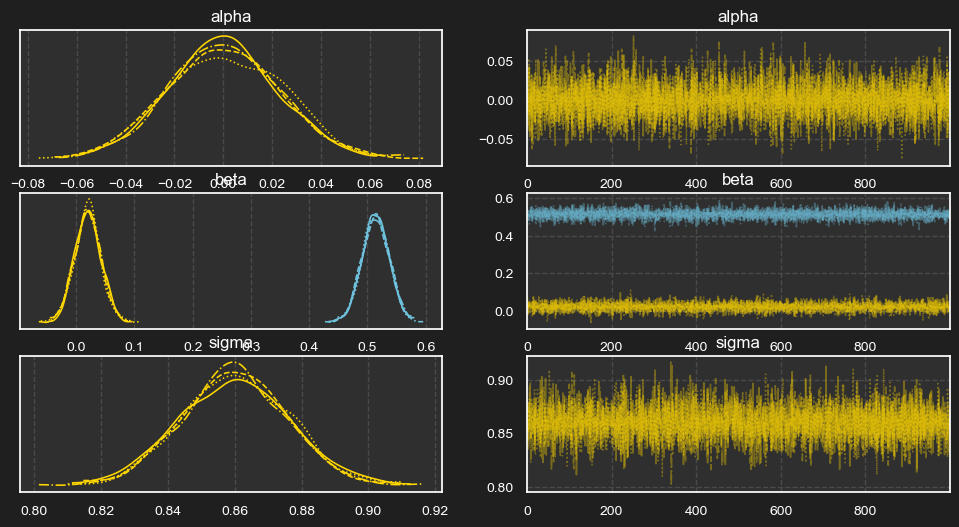

In [77]:
az.plot_trace(idata)
plt.savefig('trace_plot.pdf', bbox_inches='tight')

Sampling: [Y_obs, alpha, beta[0], beta[1], sigma, weight]


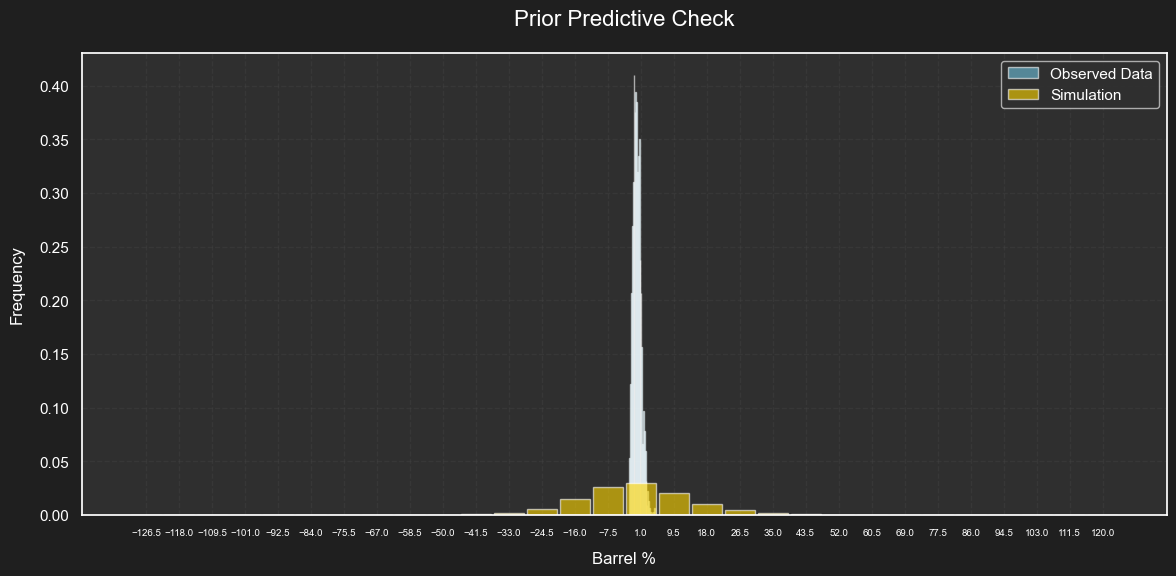

In [95]:
# Prior predictive checks before sampling
with basic_model:
    prior_checks = pm.sample_prior_predictive(samples=500)
    
    # Plot prior distributions vs observed data
    fig, ax = plt.subplots(figsize=(12,6))
    
    # Plot observed data
    az.plot_dist(
        Y, 
        kind='hist', 
        color='C1', 
        hist_kwargs={'alpha': 0.6, 'bins': 30},
        label='Observed Data',
        ax=ax
    )
    
    # Plot simulated prior predictions
    az.plot_dist(
        prior_checks.prior_predictive['Y_obs'].values.flatten(),
        kind='hist',
        color='C0',
        hist_kwargs={'alpha': 0.6, 'bins': 30},
        label='Simulation',
        ax=ax
    )
    
    # Customize plot
    plt.title("Prior Predictive Check", pad=20)
    plt.xlabel("Barrel %", fontsize=12, labelpad=10)
    plt.ylabel("Frequency", fontsize=12, labelpad=10)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=11)
    plt.legend(fontsize=11)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# **Plot Interpretation**
# Prior predictive check simulates data using only the priors. It lets us know if our priors are reasonable. 

# The support of the distribution of simulated data overlaps the support of the observered distribution of barrel rate. However there are a few negative values, but it is considered negligble.


# **Highest Posterior Density Interval**:
# The narrowest interval where: $$ p(\theta \mid X) \geq k \quad \forall \theta \in [L, U] $$ for some threshold $k$.

# The highest posterior density interval is defined such that every parameter value inside the interval has higher posterior density than every parameter value outside of it.

Text(0.5, 0, 'Standardized Effect on Barrel %')

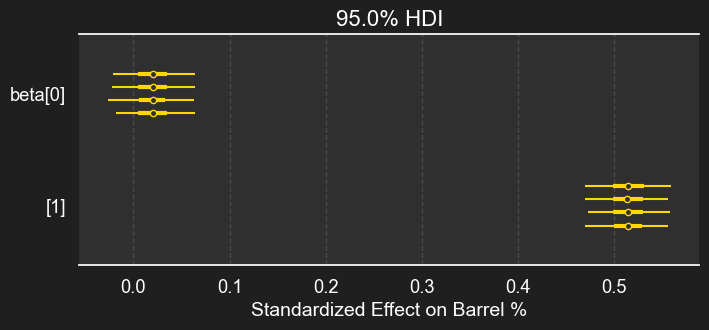

In [96]:
az.plot_forest(idata, var_names=["beta"], hdi_prob=0.95, figsize=(8, 3))
plt.xlabel("Standardized Effect on Barrel %")

# **Plot Interpretation**
# The Bayesian linear model showed a strong positive relationship between strikeout rate and barrel rate (β = 0.51, 95% Credible Interval [0.47, 0.56]). Player age had no meaningful effect (β = 0.02, HDI [-0.02, 0.06]).

# A credible interval is not the same as a confidence interval. In a Bayesian analysis, the parameter is a random variable and the information we have **(prior knowledge and the data)** is quantified by the posterior distribution. That is: a credible interval is an interval with some given posterior probability.

# Frequentists justify their confidence intervals across repeated samples, (1-α)100% of confidence intervals include the true value. The Bayesian justification is for a single sample, the credible interval has posterior probability 1-α.

# To check the robustness of the model a posterior predictive check is used to simulate data using fitted posteriors informed by the data.
# Heavy tails suggests a t-distribution is a more appropriate prior.

Sampling: [Y_obs]


Output()

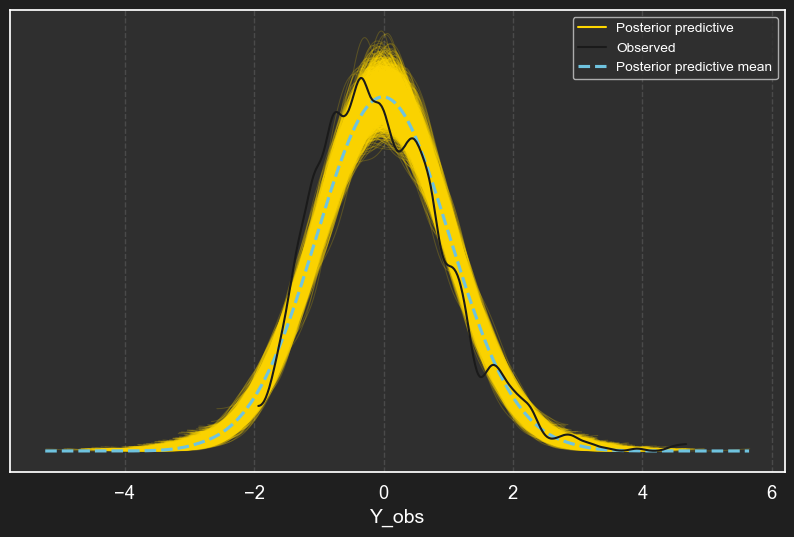

In [47]:
with basic_model:
    ppc = pm.sample_posterior_predictive(idata)
    az.plot_ppc(ppc)

plt.savefig('ppc.pdf', bbox_inches='tight')

# <span style="font-size: 25pt;">**Comments**</span>
- **1** Analysis of the posterior predictive check showed **heavy tail behaviour**. This suggests a t-distribution is a suitable distribution for the likelihood. Possible remedies are to **change the likelihood to a heavy-tailed distribution** and **include more predictors** that could help explain extreme values.

- **2** The 95% credible interval for player age spans slightly into negative values. The potential negative effect is negligble. 